### CV2 Manual Labeling with SAM implement

In [2]:
import sys
sys.path.append('/Users/steeeve/Documents/csiss/streetview_crop_classification/cropClassification')
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import numpy as np

from sam_functions import *


In [2]:
np.random.seed(42)
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
# print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs 
    # (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )
# print(bool(os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]))


Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [18]:
df_path = "/Users/steeeve/Documents/csiss/data/iowa_nebraska_labeled_imgs_filtered_reclass.json"
mask_save_path = "/Users/steeeve/Documents/csiss/data/mask_files"
model_chkpt = "/Users/steeeve/Documents/csiss/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
mask_gdf_path = "/Users/steeeve/Documents/csiss/data/mask_files/valid_img_mask.geojson"
mask_fld_path = "/Users/steeeve/Documents/csiss/data/mask_files"
filtered_mask_json = "/Users/steeeve/Documents/csiss/data/mask_files/evaluated_img_mask_pair.geojson"

In [4]:
gdf = gpd.read_file(df_path, driver="GEOJSON")
gdf_crop = gdf.loc[gdf.crop_type != "Other"].reset_index(drop=True)
gdf_crop.head()

,Name,Timestamp,Azimuth,Category,crop_type,distance,save_path,blur,geometry
0,IMG_2022_001.jpg,2022-08-09 13:54:08,154.242096,1,Maize,53.910780,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,320.966214,POINT (-134842.932 1983715.338)
1,IMG_2022_003.jpg,2022-08-09 13:54:20,143.227947,5,Soybean,71.219255,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,23.162761,POINT (-134401.764 1983428.477)
2,IMG_2022_004.jpg,2022-08-09 14:48:06,127.436863,5,Soybean,35.656663,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,325.285711,POINT (-134291.470 1983356.611)
3,IMG_2022_006.jpg,2022-08-09 14:48:09,94.960558,5,Soybean,35.759536,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,325.162918,POINT (-133973.182 1983151.187)
4,IMG_2022_007.jpg,2022-08-09 13:55:58,173.238594,1,Maize,28.213533,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,164.787409,POINT (-133639.877 1981696.371)


### Manual Labeling

In [5]:
# sam2_manual_masking(gdf_crop, [model_chkpt, model_cfg, device], mask_save_path)

In [6]:
mask_gdf = gpd.read_file(mask_gdf_path, driver="GeoJSON")
mask_gdf.head()

,Name,Timestamp,Azimuth,Category,crop_type,distance,save_path,blur,mask_score,mask_name,mask_path,geometry
0,IMG_2022_001.jpg,2022-08-09 13:54:08,154.242096,1,Maize,53.910780,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,320.966214,0.901633,IMG_2022_001_mask.jpg,/home/hanxli/data/data/mask_files/IMG_2022_001...,POINT (-134842.932 1983715.338)
1,IMG_2022_003.jpg,2022-08-09 13:54:20,143.227947,5,Soybean,71.219255,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,23.162761,0.972062,IMG_2022_003_mask.jpg,/home/hanxli/data/data/mask_files/IMG_2022_003...,POINT (-134401.764 1983428.477)
2,IMG_2022_004.jpg,2022-08-09 14:48:06,127.436863,5,Soybean,35.656663,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,325.285711,0.985273,IMG_2022_004_mask.jpg,/home/hanxli/data/data/mask_files/IMG_2022_004...,POINT (-134291.470 1983356.611)
3,IMG_2022_006.jpg,2022-08-09 14:48:09,94.960558,5,Soybean,35.759536,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,325.162918,0.947928,IMG_2022_006_mask.jpg,/home/hanxli/data/data/mask_files/IMG_2022_006...,POINT (-133973.182 1983151.187)
4,IMG_2022_007.jpg,2022-08-09 13:55:58,173.238594,1,Maize,28.213533,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,164.787409,0.950194,IMG_2022_007_mask.jpg,/home/hanxli/data/data/mask_files/IMG_2022_007...,POINT (-133639.877 1981696.371)


### Manual Inspection

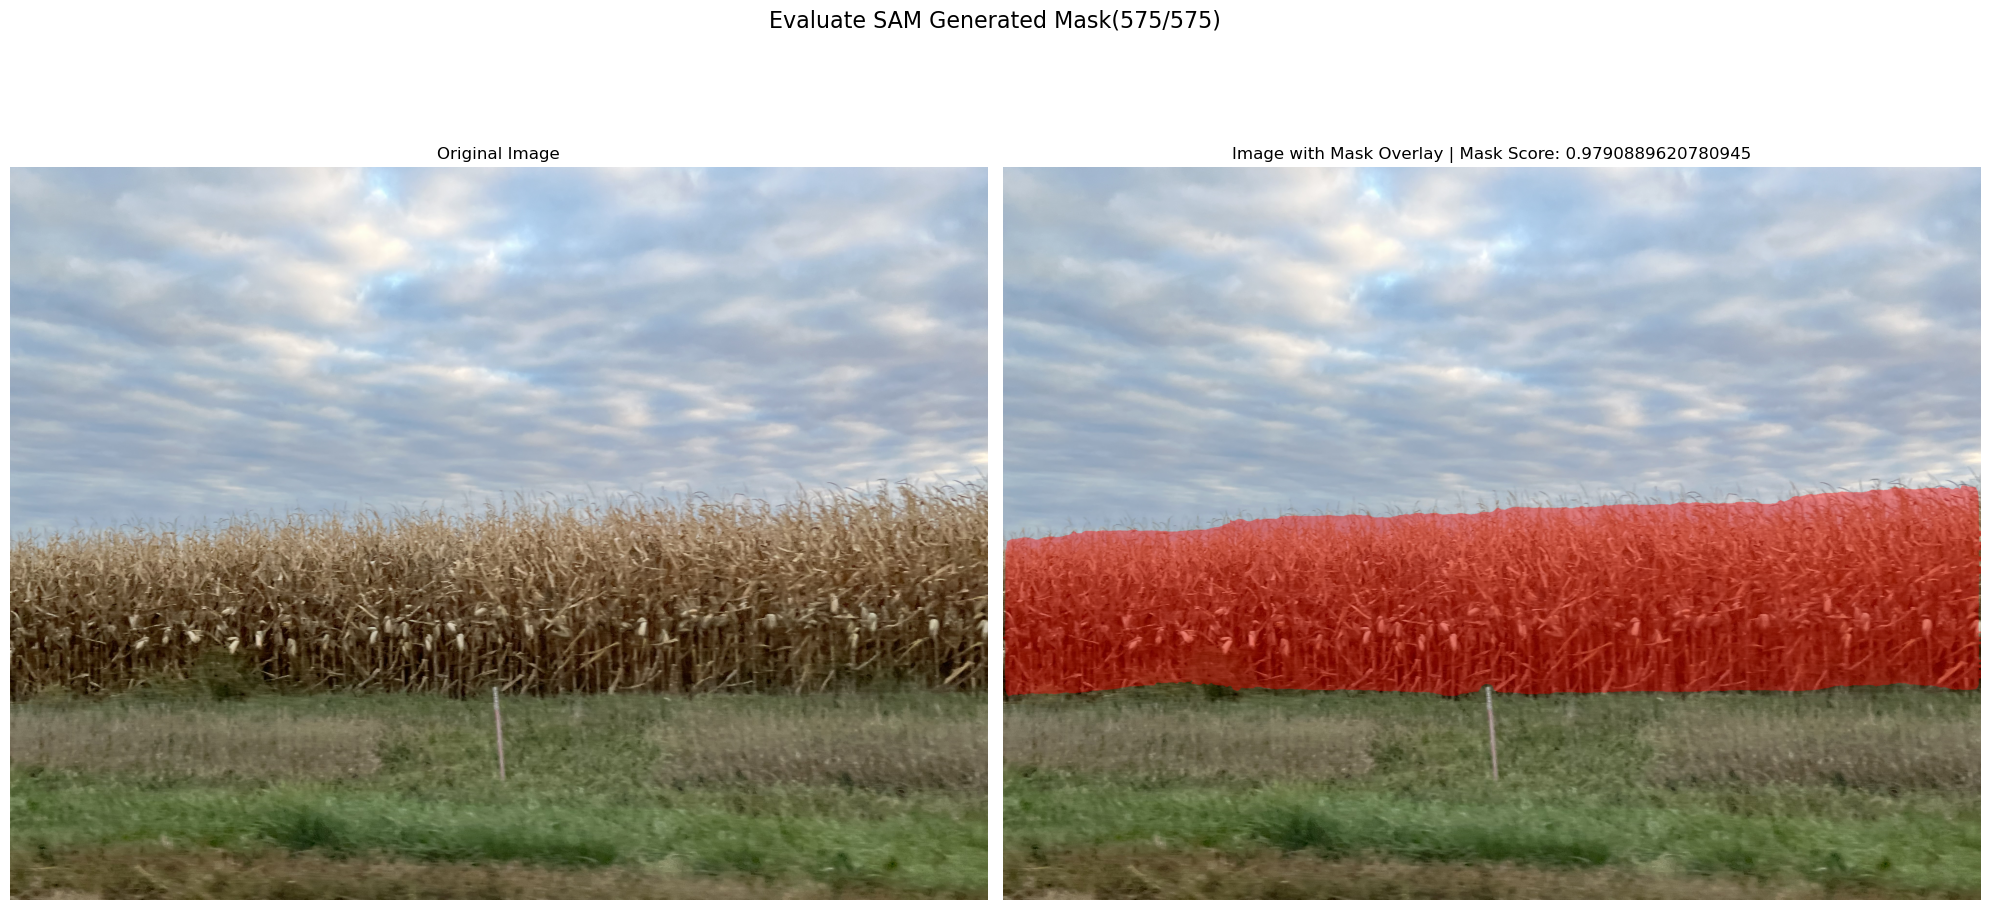


Evaluation complete. 0 mask files were deleted.


In [7]:
# %matplotlib inline
evaluate_img_mask_pair(mask_gdf, mask_fld_path, continue_index=573)

In [19]:
gdf_filtered = gpd.read_file(filtered_mask_json, driver="GEOJSON")
gdf_filtered.head(3)

,img_name,crop_type,mask_name,img_path,mask_path,mask_score,time,geometry
0,IMG_2022_001.jpg,Maize,IMG_2022_001_mask.jpg,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,/home/hanxli/data/data/mask_files/IMG_2022_001...,0.901633,2022-08-09 13:54:08,POINT (-134842.932 1983715.338)
1,IMG_2022_003.jpg,Soybean,IMG_2022_003_mask.jpg,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,/home/hanxli/data/data/mask_files/IMG_2022_003...,0.972062,2022-08-09 13:54:20,POINT (-134401.764 1983428.477)
2,IMG_2022_004.jpg,Soybean,IMG_2022_004_mask.jpg,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,/home/hanxli/data/data/mask_files/IMG_2022_004...,0.985273,2022-08-09 14:48:06,POINT (-134291.470 1983356.611)


### Generate Mask for "Other" Class

In [15]:
import geopandas as gpd
import tqdm.notebook as tqdm
import cv2
import pandas as pd

In [12]:
all_imgs_csiss = "/Users/steeeve/Documents/csiss/data/iowa_nebraska_labeled_imgs_filtered_reclass.json"
gdf = gpd.read_file(all_imgs_csiss, driver='GeoJSON')
gdf_other = gdf.loc[gdf["crop_type"] == "Other"]

In [13]:
gdf_other.head(3)

,Name,Timestamp,Azimuth,Category,crop_type,distance,save_path,blur,geometry
21,IMG_2022_026.jpg,2022-08-09 14:48:47,196.683319,176,Other,44.780266,/home/hanxli/data/data/all_sv_imgs/IMG_2022_02...,106.673079,POINT (-133680.270 1968720.174)
22,IMG_2022_027.jpg,2022-08-09 14:07:39,182.483047,176,Other,45.875203,/home/hanxli/data/data/all_sv_imgs/IMG_2022_02...,90.931047,POINT (-133656.897 1968518.156)
26,IMG_2022_033.jpg,2022-08-09 14:08:52,212.918053,176,Other,77.829121,/home/hanxli/data/data/all_sv_imgs/IMG_2022_03...,27.007862,POINT (-133755.488 1965350.406)


In [ ]:
for index, row in tqdm(gdf_other.iterrows(), total=gdf_other.shape[0], desc="Processing Images"):
    image_path = row["save_path"].replace("/home/hanxli/data/",
                                            "/Users/steeeve/Documents/csiss/")
    img_name = row["Name"].split(".")[0]
    
    # Load the image
    image = cv2.imread(image_path)
    
    if image is not None:
        # Get the height, width, and number of channels from the image
        height, width, channels = image.shape
        
        # Create a mask of zeros with the same dimensions as the image
        mask = np.zeros((height, width, channels), dtype=np.uint8)
        
        mask_filename = f"{img_name}_mask.jpg"

        mask_path = os.path.join("/Users/steeeve/Documents/csiss/data/mask_files", mask_filename)


        if os.path.exists(mask_path):
                    print(f"Mask file {mask_path} already exists. Skipping...")
        else:
            # Save the mask as a .jpg file
            cv2.imwrite(mask_path, mask)
            # print(f"Mask saved as {mask_path}")
    else:
        print(f"Image at {image_path} could not be loaded.")

In [10]:
gdf_other.head(3)

,Name,Timestamp,Azimuth,Category,crop_type,distance,save_path,blur,geometry
21,IMG_2022_026.jpg,2022-08-09 14:48:47,196.683319,176,Other,44.780266,/home/hanxli/data/data/all_sv_imgs/IMG_2022_02...,106.673079,POINT (-133680.270 1968720.174)
22,IMG_2022_027.jpg,2022-08-09 14:07:39,182.483047,176,Other,45.875203,/home/hanxli/data/data/all_sv_imgs/IMG_2022_02...,90.931047,POINT (-133656.897 1968518.156)
26,IMG_2022_033.jpg,2022-08-09 14:08:52,212.918053,176,Other,77.829121,/home/hanxli/data/data/all_sv_imgs/IMG_2022_03...,27.007862,POINT (-133755.488 1965350.406)


In [14]:
gdf_other_sorted = gdf_other.copy()
for index, row in tqdm(gdf_other_sorted.iterrows(), total=gdf_other_sorted.shape[0], desc="Processing Images"):


    mask_name = f"{row['Name'].split('.')[0]}_mask.jpg"
    mask_path = os.path.join("/home/hanxli/data/data/mask_files", mask_name)
    
    gdf_other_sorted.loc[index, "mask_name"] = mask_name
    gdf_other_sorted.loc[index, "mask_path"] = mask_path
    gdf_other_sorted.loc[index, "mask_score"] = 0

gdf_other_sorted = gdf_other_sorted[["Name", "crop_type", "mask_name", "save_path", "mask_path",
                     "mask_score", "Timestamp", "geometry"]].rename(columns={"Name": "img_name",
                                                                             "save_path": "img_path",
                                                                             "Timestamp": "time"})
gdf_other_sorted.head(3)

Processing Images:   0%|          | 0/112 [00:00<?, ?it/s]

,img_name,crop_type,mask_name,img_path,mask_path,mask_score,time,geometry
21,IMG_2022_026.jpg,Other,IMG_2022_026_mask.jpg,/home/hanxli/data/data/all_sv_imgs/IMG_2022_02...,/home/hanxli/data/data/mask_files/IMG_2022_026...,0.0,2022-08-09 14:48:47,POINT (-133680.270 1968720.174)
22,IMG_2022_027.jpg,Other,IMG_2022_027_mask.jpg,/home/hanxli/data/data/all_sv_imgs/IMG_2022_02...,/home/hanxli/data/data/mask_files/IMG_2022_027...,0.0,2022-08-09 14:07:39,POINT (-133656.897 1968518.156)
26,IMG_2022_033.jpg,Other,IMG_2022_033_mask.jpg,/home/hanxli/data/data/all_sv_imgs/IMG_2022_03...,/home/hanxli/data/data/mask_files/IMG_2022_033...,0.0,2022-08-09 14:08:52,POINT (-133755.488 1965350.406)


In [20]:
gdf_concat = pd.concat([gdf_filtered, gdf_other_sorted], ignore_index=True)

# Reset the index after concatenation
gdf_concat = gdf_concat.reset_index(drop=True)
gdf_concat.head()

,img_name,crop_type,mask_name,img_path,mask_path,mask_score,time,geometry
0,IMG_2022_001.jpg,Maize,IMG_2022_001_mask.jpg,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,/home/hanxli/data/data/mask_files/IMG_2022_001...,0.901633,2022-08-09 13:54:08,POINT (-134842.932 1983715.338)
1,IMG_2022_003.jpg,Soybean,IMG_2022_003_mask.jpg,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,/home/hanxli/data/data/mask_files/IMG_2022_003...,0.972062,2022-08-09 13:54:20,POINT (-134401.764 1983428.477)
2,IMG_2022_004.jpg,Soybean,IMG_2022_004_mask.jpg,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,/home/hanxli/data/data/mask_files/IMG_2022_004...,0.985273,2022-08-09 14:48:06,POINT (-134291.470 1983356.611)
3,IMG_2022_006.jpg,Soybean,IMG_2022_006_mask.jpg,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,/home/hanxli/data/data/mask_files/IMG_2022_006...,0.947928,2022-08-09 14:48:09,POINT (-133973.182 1983151.187)
4,IMG_2022_007.jpg,Maize,IMG_2022_007_mask.jpg,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,/home/hanxli/data/data/mask_files/IMG_2022_007...,0.950194,2022-08-09 13:55:58,POINT (-133639.877 1981696.371)


In [21]:
np.unique(gdf_concat["crop_type"], return_counts=True)

(array(['Maize', 'Other', 'Soybean'], dtype=object), array([389, 112, 186]))

In [22]:
gdf_concat.to_file("/Users/steeeve/Documents/csiss/data/maize_soyb_training.geojson", driver="GeoJSON")